# ANALYSE DES ANOMALIES DE GEOPOTENTIEL avec un seuil constant

# **1. IMPORTATION DES MODULES ET DES DONNEES**

In [6]:
import requests
import tempfile
import numpy as np
import xarray as xr
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature

Les données ont été téléchargée du site Climate Data Store. La fréquence des données est journalière, à 12h00 (Hersbach et al, 2023. Muñoz, 2019).

```data_40``` comprend des données de 1940 à 2024, dans une petite région autour de Bruxelles.

La commande 
``
chunk({'valid_time': 100}
``
est nécessaire car le volume de données est très grand.

In [ ]:
#Données uniquement pour latitude = [50.4, 50.6] & longitude = [4.2, 4.3] de 1950 à 2024
url_nc = "https://raw.githubusercontent.com/clemence-g/Heat-dome-analysis/67a10c89e5c0c5b9b0c5460a376825d81a027722/Data/geopotential_bruxelles.nc"


data_50 = xr.open_dataset(url_nc, engine="netcdf4").chunk({'valid_time': 100})
data_50 = data_50['z']
data_50 = data_50.sel(valid_time = slice("1950-01-01","2024-12-31")) #on coupe à partir de 1950 pour que ce soit les mêmes dates que pour le fichier des températures à Bruxelles

Nous utilisons égalemnet un ensemble de données de température à 2m d'altitude qui contient les données pour l'hémisphère nord.
Deux dataset sont utilisés:
- Le fichier ```temperature_bx```contient les données de 1950 à 2024.\
- Le fichier ```temperature``` contient les données de toute l'hémisphère nord de 1994 à 2024.
La commande
``
chunk
``
est également nécessaire en raison du volume de données.\
Une conversion de degré kelvin en degré celsius est utilisée en soustrayant 273.15 aux données initiales.

In [ ]:
#Données uniquement pour latitude = [50.4, 50.6] & longitude = [4.2, 4.3] de 1950 à 2024
temperature_data_bx = xr.open_dataset( "https://raw.githubusercontent.com/clemence-g/Heat-dome-analysis/main/Data/temp_bx.nc", engine='netcdf4').chunk({'valid_time': 100})
temperature_K_bx = temperature_data_bx['t2m']
temperature_bx = temperature_K_bx - 273.15

Le dictionnaire ``coord``contient les coordonnées de latitude et de longitude en valeurs décimales des villes utilisées.

In [5]:
coord = {
    "Bruxelles" : {"latitude" : 50.50,     "longitude" : 4.21}
}

# **2. ANALYSE DES DONNEES**

## **2.1 Distribution des données**

### Histogrammes

In [8]:
def hist_data(data,place):
    
    lat = coord[place]["latitude"]
    lon = coord[place]["longitude"]
    
    selected_data = data.sel(longitude = lon, latitude = lat, method = 'nearest')
    
    dates_list = data['valid_time'].values #extraire les dates présentes dans le fichier

    #Les 6 lignes suivantes servent à déterminer les unités et le nom des données afin de les afficher dans les graphiques.
    if np.mean(selected_data.values.flatten()) > 1000:
        donnee = "géopotentiel"
        unite = "m²/s²"
    else : 
        donnee = "température"
        unite = "°C" 
    
    plt.figure(figsize=(10, 5))

    #Histogramme
    plt.hist(selected_data.values.flatten(), bins=100, color="lightgreen", density=False)

    #Moyenne
    plt.axvline(selected_data.mean().values, color="blue", ls="--", label=f"Moyenne = {selected_data.mean().values:.2f} {unite}")
    
    plt.legend()    
    plt.title(f"Distribution des données de {donnee} à {place} \nLatitude = {lat}°, Longitude = {lon}° \nPériode {str(dates_list[0])[:10]} -> {str(dates_list[-1])[:10]}")    
    plt.xlabel(f"Valeurs de {donnee} ({unite})")
    plt.ylabel("Nombre d'occurences des valeurs")
    plt.show()

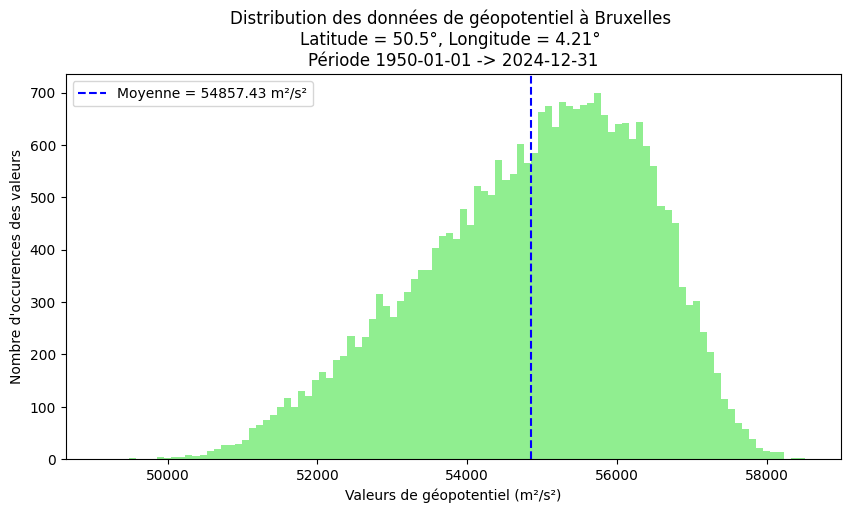

In [9]:
hist_data(data_50,"Bruxelles")

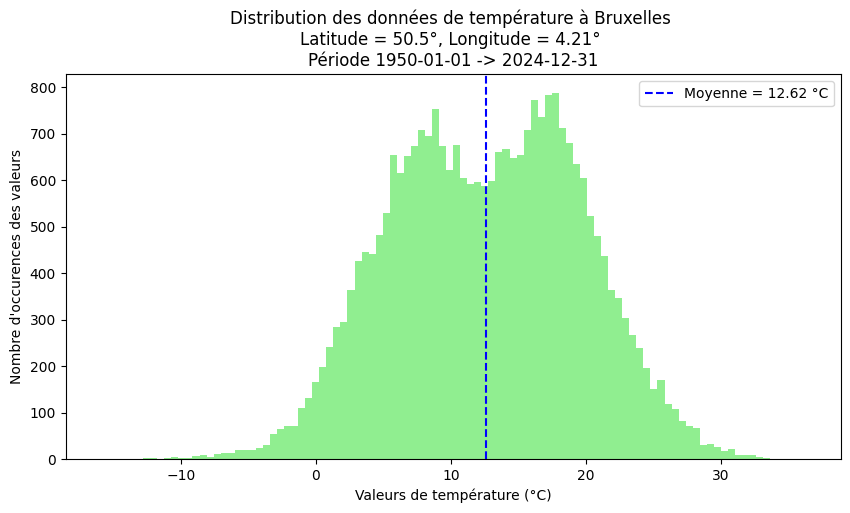

In [10]:
hist_data(temperature_bx,"Bruxelles")

## **2.2 Densité de probabilité et loi de distribution**

### 2.2.1 Test de log-vraisemblance

La distribution des données de géopotentiel semble asymétrique, avec une asymétrie négative (les valeurs sont plus "étalées" à gauche). Cela se confirme en calculant le coefficient d'asymétrie avec scipy.

In [11]:
skewness = stats.skew(data_50.sel(longitude = coord["Bruxelles"]["longitude"], latitude = coord["Bruxelles"]["latitude"], method = 'nearest'))
print("Skewness =", skewness)

Skewness = [-0.45309812]


Pour comprendre cette asymétrie trouver la loi de distribution qui se rapproche le plus des données, on compare la fonction de densité de probabilité des données avec plusieurs lois issues du module scipy. On exclut la loi normale puisque la distribution des données est asymétrique. La ressemblance est établie en calculant la log-vraissemblance avec la fonction 
``
logpdf
``
de scipy. Plus la valeur est grande, plus la distribution de probabilité est proche des données.

In [12]:
def hist_fit(data, place):
    
    lat = coord[place]["latitude"]
    lon = coord[place]["longitude"]
    
    selected_data = data.sel(longitude = lon, latitude = lat, method = 'nearest')
    
    plt.figure(figsize=(10, 5))
    plt.hist(selected_data.values.flatten(), bins = 100, color = "lightgreen", density=True)

    x = np.linspace(selected_data.min().values, selected_data.max().values, 1000)

    distribution_list=["weibull_min","gumbel_l","powernorm","skewnorm"]
    color_list =["red","lightblue","grey","black","purple"]

    ll_list ={}

    for distribution,color in zip(distribution_list, color_list):
        dist = getattr(stats, distribution)
        param = dist.fit(selected_data)
        
        pdf_distribution = dist.pdf(x, *param)
        plt.plot(x, pdf_distribution, color, linestyle='-.', label=f"Loi de {distribution}")
        
        # Log-vraisemblance
        ll_distribution = np.sum(dist.logpdf(selected_data, *param))
        ll_list[distribution]=ll_distribution
        
        print(f"Log-vraisemblance pour la distribution {distribution} :", ll_distribution)
    
    best_fit = max(ll_list, key=ll_list.get)
    print("La distribution la plus adaptée est :", best_fit)

    if np.mean(selected_data.values.flatten()) > 1000:
        donnee = "géopotentiel"
        unite = "m²/s²"
    else : 
        donnee = "température"
        unite = "°C"        
    
    plt.legend()    
    plt.title(f"Densité de probabilité des données de {donnee} à {place}")
    plt.xlabel(f"Valeurs de {donnee} {unite}")
    plt.ylabel("Densité de probabilité")
    plt.show()

Log-vraisemblance pour la distribution weibull_min : -238323.12774791024
Log-vraisemblance pour la distribution gumbel_l : -238595.26716456967
Log-vraisemblance pour la distribution powernorm : -238402.8036341742
Log-vraisemblance pour la distribution skewnorm : -238257.08199143666
La distribution la plus adaptée est : skewnorm


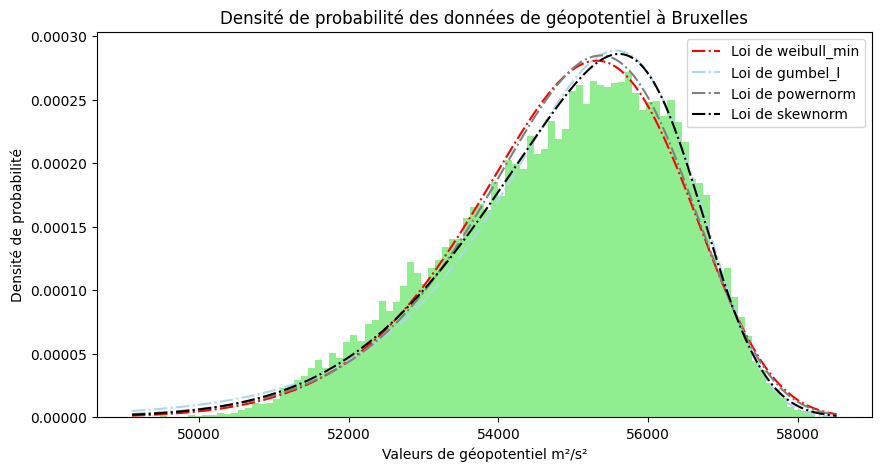

In [13]:
hist_fit(data_50,"Bruxelles")

La loi de distribution la plus appropriée est donc celle de la *skewnorm*, soit une normale asymétrique. Dans l'étude de **Domeisen. et al (2023)**, les auteur.ice.s observent la même distribution pour les températures : elles penchent vers les valeurs plus hautes, ce qui indique que les évènements extrêmes se produisent plus fréquemment que pour une distribution normale.

Log-vraisemblance pour la distribution weibull_min : -inf
Log-vraisemblance pour la distribution gumbel_l : -93613.63606564984
Log-vraisemblance pour la distribution powernorm : -92171.83449020816
Log-vraisemblance pour la distribution skewnorm : -92170.25527443583
La distribution la plus adaptée est : skewnorm


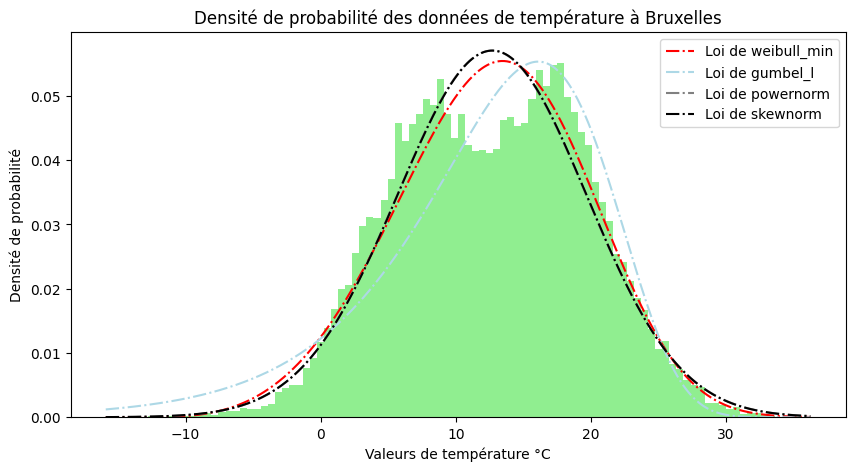

In [14]:
hist_fit(temperature_bx,"Bruxelles")

Le test de log-vraisemblance indique que la distribution la plus adaptée est la powernorm, avec un écart de 11 unités avec la skewnorm.
Cependant, notre distribution des données de températures pour Bruxelles ressemble à une distribution bi-modale. Cela pourrait s'expliquer par l'existence de deux modes principaux de température: l'hiver et l'été. La distribution des température pourrait être la somme de deux lois normales asymétriques.

### 2.2.2 Test de Komogorov-Smirnov unilatéral

Nous pouvons vérifier que la normale asymétrique est adaptée aux données en effectuant le test de kolmogorov-Smirnov.
- Le paramètre "statistic" détermine l'écart maximal entre la distribution cumulative des données et la distribution cumulative de la normale asymétrique qui correspoond à la distribution. Plus elle est grande, plus les distributions diffèrent.
- Une p-value supérieure à 0.05 indique que les données ne suivent probablement pas une normale asymétrique.

In [15]:
def kolmogorov_unilateral(data, place):

    lat = coord[place]["latitude"]
    lon = coord[place]["longitude"]
    
    selected_data = data.sel(longitude=lon, latitude=lat, method='nearest')

    date_list = selected_data['valid_time'].values

    if np.mean(selected_data.values.flatten()) > 1000:
        donnee = "géopotentiel"
        unite = "m²/s²"
    else: 
        donnee = "température"
        unite = "°C"

    # Il faut d'abord applatir les données
    selected_data_applati = selected_data.values.flatten()

    # Ajustement de la distribution skewnorm aux données aplaties
    params = stats.skewnorm.fit(selected_data_applati)
    skew_param = params[0]  # premier paramètre est le skew
    loc, scale = params[1], params[2]

    # Test de Kolmogorov-Smirnov
    statistic, pvalue = stats.ks_1samp(selected_data_applati, lambda x: stats.skewnorm.cdf(x, skew_param, loc, scale))

    print(f"Résultats du test de Kolmogorov pour les données de {donnee} pour {str(date_list[0])[:4]}-{str(date_list[-1])[:4]}")
    print(f"statistics = {statistic} \npvalue = {pvalue}")


In [16]:
kolmogorov_unilateral(data_50,"Bruxelles")

Résultats du test de Kolmogorov pour les données de géopotentiel pour 1950-2024
statistics = 0.02237886499213404 
pvalue = 2.3817593045278842e-12


Pour les données de géopotentiel, le test Kolmogorov-Smirnov a renvoyé une statistique de $0.02237$ et une p-value de $2.38 \times 10^{-12}$, ce qui indique que les données suivent une distribution skewnorm avec une probabilité relativement faible de ne pas l'être (p-value inférieure à 0.05). Cela signifie que la distribution skewnorm semble bien correspondre aux données de géopotentiel pour la période 1994-2024.

In [17]:
kolmogorov_unilateral(temperature_bx,"Bruxelles")

Résultats du test de Kolmogorov pour les données de température pour 1950-2024
statistics = 0.036911895339696854 
pvalue = 7.27054412366825e-33


Pour les données de température, le test Kolmogorov-Smirnov a renvoyé une statistique de $0.035$ et une p-value de $1.54 \cdot 10^{-12}$, ce qui indique que les données suivent une distribution skewnorm avec une probabilité relativement faible de ne pas l'être (p-value inférieure à 0.05). Cela signifie que la distribution skewnorm semble bien correspondre aux données de température pour la période 1994-2024.

## **2.3 Tendance temporelle des données**

Il serait intéressant de comparer la distribution des données selon la période de temps prise en compte. On utilise le dataset 
``
data_40
``
et on sépare les données en deux périodes : 1940-1982 et 1983-2024.

### 2.3.1 Variables statistiques

In [18]:
def comp(data, place):
 
    lat = coord[place]["latitude"]
    lon = coord[place]["longitude"]
    
    selected_data = data.sel(longitude = lon, latitude = lat, method = 'nearest')

    date_list = selected_data['valid_time'].values

    year_1 = int(str(date_list[0])[:4])
    year_3 = int(str(date_list[-1])[:4])
    year_2 = (year_3 + year_1)/2

    
    first_data = selected_data.sel(valid_time = slice(f"{str(year_1)[:4]}-01-01", f"{str(year_2)[:4]}-12-31"))
    last_data = selected_data.sel(valid_time=slice(f"{str(year_2+1)[:4]}-01-01", f"{str(year_3)[:4]}-12-31"))

    if np.mean(selected_data.values.flatten()) > 1000:
        donnee = "géopotentiel"
        unite = "m²/s²"
    else : 
        donnee = "température"
        unite = "°C"
        
    print(f"Données de {donnee}")
    print(f"\nPériode : {str(year_1)[:4]} - {str(year_2)[:4]}")
   
    print(f"\nMoyenne : {np.mean(first_data.values):.2f} {unite}")
    print(f"Médiane : {np.median(first_data.values):.2f} {unite}")
    print(f"Variance : {np.var(first_data.values):.2f} {unite}")
    print(f"Ecart-type : {np.std(first_data.values):.2f} {unite}")
    print(f"Min ; Max : {np.min(first_data.values):.2f} ; {np.max(first_data.values):.2f} {unite}")
    
    print(f"\nPériode : {str(year_2+1)[:4]} - {str(year_3)[:4]}")
    
    print(f"\nMoyenne : {np.mean(last_data.values):.2f} {unite}")
    print(f"Médiane : {np.median(last_data.values):.2f} {unite}")
    print(f"Variance : {np.var(last_data.values):.2f} {unite}")
    print(f"Ecart-type : {np.std(last_data.values):.2f} {unite}")
    print(f"Min ; Max : {np.min(last_data.values):.2f} ; {np.max(last_data.values):.2f} {unite}")

In [19]:
comp(temperature_bx, "Bruxelles")

Données de température

Période : 1950 - 1987

Moyenne : 11.99 °C
Médiane : 12.25 °C
Variance : 49.12 °C
Ecart-type : 7.01 °C
Min ; Max : -15.91 ; 32.35 °C

Période : 1988 - 2024

Moyenne : 13.27 °C
Médiane : 13.33 °C
Variance : 48.02 °C
Ecart-type : 6.93 °C
Min ; Max : -10.95 ; 36.24 °C


| Paramètres (°C)   | 1950 - 1987   |1987 - 2024    |
| -------------     |:-------------:|:-------------:|
| Moyenne           | 11.99         |13.27          |
| Médiane           | 12.25         |13.33          |
| Variance          | 49.12         |48.02          |
| Ecart-type        | 7.01          |6.93           |
| Minimum           | -15.91        |-10.95         |
| Maximum           | 32.35         |36.23          |

Pour la température , on voit que **toutes les variables augmentent** sauf la variance et l'écart-type.

In [20]:
comp(data_50, "Bruxelles")

Données de géopotentiel

Période : 1950 - 1987

Moyenne : 54735.38 m²/s²
Médiane : 54895.23 m²/s²
Variance : 2282904.75 m²/s²
Ecart-type : 1510.93 m²/s²
Min ; Max : 49506.68 ; 58393.11 m²/s²

Période : 1988 - 2024

Moyenne : 54982.78 m²/s²
Médiane : 55175.62 m²/s²
Variance : 2150626.75 m²/s²
Ecart-type : 1466.50 m²/s²
Min ; Max : 49108.34 ; 58515.32 m²/s²


| Paramètres (m²/s²)| 1950 - 1987   |1987 - 2024    |
| -------------     |:-------------:|:-------------:|
| Moyenne           | 54 735.38     |54 982.78      |
| Médiane           | 54 895.23     |55 175.62      |
| Variance          | 2 282 904.75  |2 150 626.75   |
| Ecart-type        | 1 510.93      |1 466.50       |
| Minimum           | 49 506.68     |49 108.34      |
| Maximum           | 58 393.11     |58 515.32      |

Pour les données de géopotentiel, on voit que :
- La moyenne, la médiane et le maximum **augmentent**;
- La variance, l'écart-type et le  minimum **diminuent**.

### 2.3.2 Graphiques des distributions

In [21]:
# Histogramme
def comp_hist(data, place):

    lat = coord[place]["latitude"]
    lon = coord[place]["longitude"]
    
    selected_data = data.sel(longitude = lon, latitude = lat, method = 'nearest')

    date_list = selected_data['valid_time'].values

    year_1 = int(str(date_list[0])[:4])
    year_3 = int(str(date_list[-1])[:4])
    year_2 = (year_3 + year_1)/2

    
    first_data = selected_data.sel(valid_time = slice(f"{str(year_1)[:4]}-01-01", f"{str(year_2)[:4]}-12-31"))
    last_data = selected_data.sel(valid_time=slice(f"{str(year_2+1)[:4]}-01-01", f"{str(year_3)[:4]}-12-31"))

    if np.mean(selected_data.values.flatten()) > 1000:
        donnee = "géopotentiel"
        unite = "m²/s²"
    else : 
        donnee = "température"
        unite = "°C"
    
    plt.figure(figsize=(12, 4))
    
    # Histogramme = densité réelle
    
    plt.subplot(1, 2, 1)
    plt.hist(first_data.values.flatten(), bins=50, alpha=0.5, label=f"{str(year_1)[:4]} - {str(year_2)[:4]}", density=True)
    plt.hist(last_data.values.flatten(), bins=50, alpha=0.5, label=f"{str(year_2+1)[:4]} - {str(year_3)[:4]}", density=True)
    plt.legend()
    plt.title(f"Histogramme des valeurs de {donnee} \nà {place}")

    # KDE Plot = densité lissée/estimée
    
    plt.subplot(1, 2, 2)
    sns.kdeplot(first_data.values.flatten(), label=f"{str(year_1)[:4]} - {str(year_2)[:4]}", fill=True)
    sns.kdeplot(last_data.values.flatten(), label=f"{str(year_2+1)[:4]} - {str(year_3)[:4]}", fill=True)
    plt.legend()
    plt.title(f"Densité estimée de {donnee} \nà {place}")
    
    plt.show()

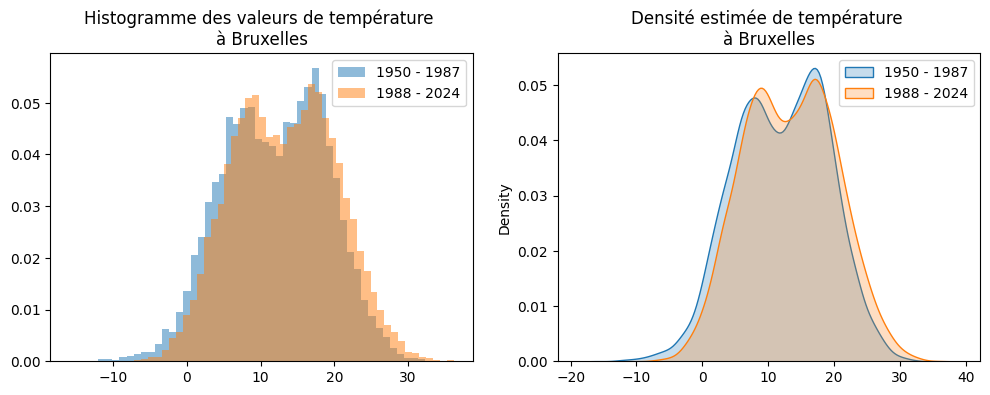

In [22]:
comp_hist(temperature_bx, "Bruxelles")

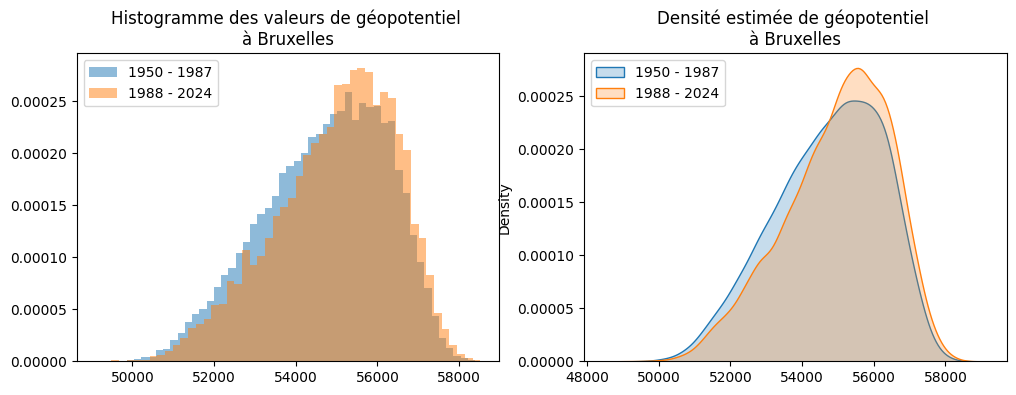

In [23]:
comp_hist(data_50, "Bruxelles")

### 2.3.3 Test de Kolmogorov-Smirnov bilatéral

Le test de Kolmogorov-Smirnov **bilatéral** sert à déterminer si deux échantillons de données suivent la même distribution. 
- La valeur ```statistic``` mesure la différence maximale entre les distributions cumulées des deux échantillons. Plus elle est grande, plus les distributions diffèrent.
- La p-value mesure le niveau de confiance. On choisit une p-value de 95 %, ce qui signifie que nous rejetons l'hypothèse nulle (H₀ : les deux échantillons suivent la même distribution) si la p-valeur est inférieure à 0,05. Dans ce cas, nous concluons que les deux échantillons ne suivent pas la même distribution.

In [24]:
def kolmogorov_bilateral(data,place):

    lat = coord[place]["latitude"]
    lon = coord[place]["longitude"]
    
    selected_data = data.sel(longitude = lon, latitude = lat, method = 'nearest')

    date_list = selected_data['valid_time'].values

    year_1 = int(str(date_list[0])[:4])
    year_3 = int(str(date_list[-1])[:4])
    year_2 = (year_3 + year_1)/2

    
    first_data = selected_data.sel(valid_time = slice(f"{str(year_1)[:4]}-01-01", f"{str(year_2)[:4]}-12-31"))
    last_data = selected_data.sel(valid_time=slice(f"{str(year_2+1)[:4]}-01-01", f"{str(year_3)[:4]}-12-31"))

    if np.mean(selected_data.values.flatten()) > 1000:
        donnee = "géopotentiel"
        unite = "m²/s²"
    else : 
        donnee = "température"
        unite = "°C"
    
    #Applatissement des données
    first_data_applati = first_data.values.flatten()
    last_data_applati = last_data.values.flatten()

    #test de kolmogorov
    statistic, pvalue =  stats.ks_2samp(first_data_applati, last_data_applati)
    print(f"Résultats du test de Kolmogorov pour les données de {donnee} pour les périodes {str(year_1)[:4]} - {str(year_2)[:4]} et {str(year_2+1)[:4]} - {str(year_3)[:4]}")
    print(f"statistics = {statistic} \npvalue = {pvalue}")

In [25]:
kolmogorov_bilateral(temperature_bx,"Bruxelles")

Résultats du test de Kolmogorov pour les données de température pour les périodes 1950 - 1987 et 1988 - 2024
statistics = 0.06186416359968827 
pvalue = 3.186811816249365e-23


In [26]:
kolmogorov_bilateral(data_50, "Bruxelles")

Résultats du test de Kolmogorov pour les données de géopotentiel pour les périodes 1950 - 1987 et 1988 - 2024
statistics = 0.0747914037547231 
pvalue = 9.367182944645851e-34


- Statistique = $0.07479$
- La p-valeur étant extrêmement faible ($9.367 \times 10^{-34} <<< 0.05$), cela signifie qu’il y a une différence significative entre les deux périodes. En d'autres termes, la distribution du géopotentiel n'est pas la même entre 1940-1982 et 1983-2024.

# **3. CALCUL D'ANOMALIES**

Une vague de chaleur sera définie ici sur base du concept d'anomalie. On définit d'abord un seuil au-dessus duquel un jour est considéré comme une anomalie. Si au moins 5 jours d'anomalies se suivent, alors il s'agit d'une vague de chaleur.
Pour étudier le concept de dôme de chaleur, on analyse les anomalies de géopotentiel.

La première étape est de définir le seuil à partir duquel un jour est une anomalie.

## 3.1 Seuil défini comme $\mu +2\sigma$

Une première approche est de fixer un seuil de géopotentiel comme $\mu + 2\sigma$, où $\mu$ est la moyenne et $\sigma$ est l'écart-type des données.

In [7]:
def seuil(data,place):
    lat = coord[place]["latitude"]
    lon = coord[place]["longitude"]
    
    selected_data = data.sel(longitude = lon, latitude = lat, method = 'nearest')

    #Statistiques calculées au point lat,lon
    ecart_type = selected_data.std().values
    mean = selected_data.mean().values
    treshold = mean + 2*ecart_type

    return treshold

In [8]:
def seuil_1(data,place):
    lat = coord[place]["latitude"]
    lon = coord[place]["longitude"]
    
    selected_data = data.sel(longitude = lon, latitude = lat, method = 'nearest')

    #Statistiques calculées au point lat,lon
    ecart_type = selected_data.std().values
    mean = selected_data.mean().values
    treshold = mean + ecart_type

    return treshold

## 3.2 Seuil défini comme quartile

La seconde approche est de fixer le seuil comme le $95^e$ percentile de la distribution, afin d'extraire les $5\%$ de données de plus haut géopotentiel.
Ainsi, pour qu'un jour soit comptabilisé comme anomalie, il faut qu'il soit situé au-dessus de ce seuil. On calcule ce seuil directement avec la fonction ```percentile``` du module ```numpy```.

In [6]:
def seuil_p(data, place,q):
    
    lat = coord[place]["latitude"]
    lon = coord[place]["longitude"]
    
    selected_data = data.sel(longitude = lon, latitude = lat, method = 'nearest')
    
    treshold = np.percentile(selected_data.values.flatten(), q)  # q-ième percentile : q% des données sont en dessous de ce seuil

    return treshold

## 3.3 Comparaison des deux définitions de seuil pour Bruxelles

In [9]:
treshold = seuil(data_50,"Bruxelles")
treshold_1 = seuil_1(data_50,"Bruxelles")
treshold_p = seuil_p(data_50, "Bruxelles", q=95)
print(f"Seuil calculé comme µ +sigma : {treshold_1:.2f} m²/s²")
print(f"Seuil calculé comme µ +2*sigma : {treshold:.2f} m²/s²")
print(f"Seuil basé sur le 99e percentile : {treshold_p:.2f} m²/s²")

Seuil calculé comme µ +sigma : 56351.73 m²/s²
Seuil calculé comme µ +2*sigma : 57846.04 m²/s²
Seuil basé sur le 99e percentile : 57002.32 m²/s²


On peut visualiser la position de ces seuils sur un histogramme des données de géopotentiel. 

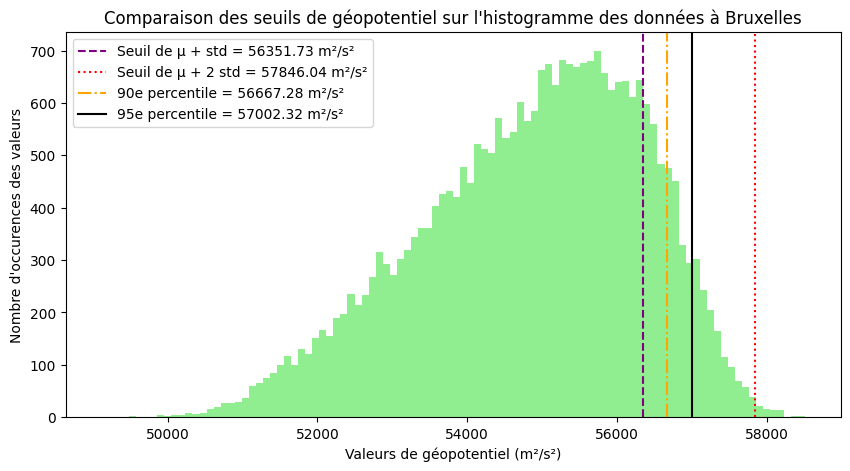

In [10]:
selected_data = data_50.sel(longitude = coord["Bruxelles"]["longitude"], latitude = coord["Bruxelles"]["latitude"], method = 'nearest')
    
plt.figure(figsize=(10, 5))

#Histogramme
plt.hist(selected_data, bins = 100, color = "lightgreen", density=False)
plt.axvline(treshold_1, color = "purple",linestyle="dashed", label = f"Seuil de µ + std = {treshold_1:.2f} m²/s²")
plt.axvline(treshold, color = "red", linestyle="dotted", label = f"Seuil de µ + 2 std = {treshold:.2f} m²/s²")
plt.axvline(np.percentile(selected_data.values.flatten(), 90), color = "orange", linestyle = "dashdot", label = f"90e percentile = {np.percentile(selected_data.values.flatten(), 90):.2f} m²/s²")
plt.axvline(treshold_p, color = "black", label = f"95e percentile = {treshold_p:.2f} m²/s²")

plt.legend()    
plt.title(f"Comparaison des seuils de géopotentiel sur l'histogramme des données à Bruxelles")    
plt.xlabel("Valeurs de géopotentiel (m²/s²)")
plt.ylabel("Nombre d'occurences des valeurs")
plt.show()

On voit que :
- le seuil défini à l'aide de la moyenne et de l'écart-type exclut beaucoup plus de données que le 95e percentile ;
- Il n'est pas facile à modifier, car $\mu + \sigma$ est trop faible et $\mu + 3 \sigma$ est trop haut et ne laisse passer aucune donnée ;
- Le seuil défini comme percentile paraît plus rigoureux et pertinent quant à la définition d'anomalie;
(Barriopedro et al., 2023; Domeisen et al., 2023).
- Dans la suite, on utilisera alors le seuil fixe définit comme un percentile de la distribution.

## **3.2 Application du seuil**

### 3.2.1 Evolution temporelle de la fréquence des anomalies

In [31]:
def graph(data,place,q):
    lat = coord[place]["latitude"]
    lon = coord[place]["longitude"]

    selected_data = data.sel(longitude = lon, latitude = lat, method = 'nearest')

    dates_list = selected_data['valid_time'].values

    treshold = seuil_p(data, place,q)
    
    high_values_all_dates = selected_data.where(selected_data > treshold)

    plt.figure(figsize=(10, 5))

    plt.scatter(dates_list, selected_data, label="Jours de valeurs normales", color="blue", s=1)
    plt.scatter(high_values_all_dates["valid_time"], high_values_all_dates, color="red", label="Jours au-dessus du seuil", s=1)
    plt.axhline(treshold, color="green", ls="--", label=f"Seuil ({round(treshold)} m²/s²)")

    plt.xlabel("Date")
    plt.ylabel("Géopotentiel (m²/s²)")
    plt.title(f"Evolution du géopotentiel à 500 hPa à {place} (Latitude = {lat}°, Longitude = {lon}°) \n Période : {str(dates_list[0])[:10]} -> {str(dates_list[-1])[:10]}")
    plt.xticks(rotation=45)
    
    plt.legend()
    plt.show()

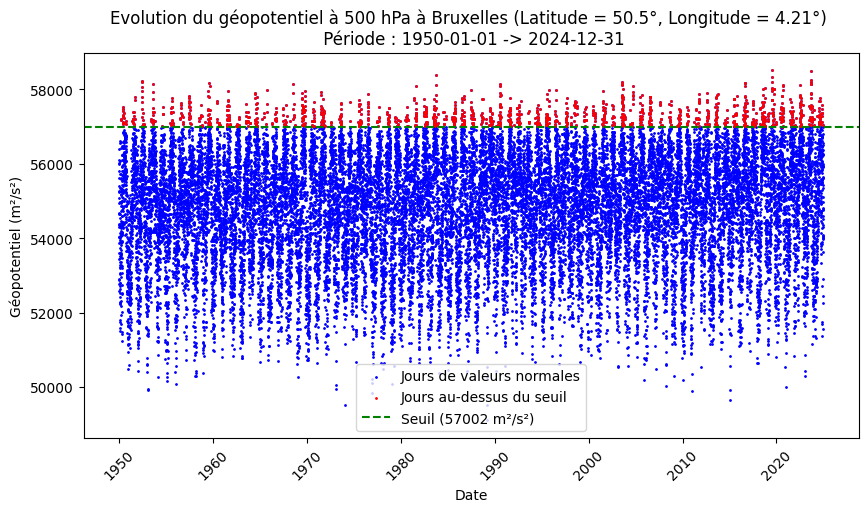

In [32]:
graph(data_50,"Bruxelles",q=95)

On voit que les données ont une forme sinusoïdale. Elles varient sur une période d'un an et en fonction des saisons. En fixant le seuil comme constant en fonction du temps, on voit que les valeurs estivales dépassent régulièrement le seuil, mais pas les valeurs hivernales. On voit aussi que de plus en plus de valeurs dépassent le seuil au fur et à mesure du temps. \
On pourrait implémenter un seui qui varie de manière saisonnière, mais ce choix ne serait pas pertinent car une anomalie de géopotentiel en hiver n'a pas la même signification qu'en été, où elle peut s'assimiler à un dôme de chaleur.\
Le seuil a été choisi constant au fil des années sans moyenne glissante, pour plusieurs raisons. L'argument principal est que le changement climatique anthropique est récent à l'échelle de l'évolution humaine. Le programme détecte plus d'anomalies dans les dernières années. On pourrait penser que cela influence la détection et fait que le programme ne détecte pas les dômes de chaleur dans les données plus anciennes. Cependant, il paraît important à l'autrice de laisser le programme indiquer cette fréquence plus importante de vagues de chaleur dans les dernières années, car le corps humain n'a pas encore eu le temps de s'y adapter et inclure l'effet du changemenent climatique dans la détermination du seuil de géopotentiel reviendrait à "effacer" ses conséquences, visibles dans les données.

### 3.2.2 Nombre annuel de jours au-dessus du seuil

On voit encore plus cette tendance en définissant un "indice" d'anomalies, qui calcule le nombre de jours par années qui dépassent le seuil.

In [34]:
def depassement(data,place,q):

    lat = coord[place]["latitude"]
    lon = coord[place]["longitude"]

    selected_data = data.sel(latitude = lat, longitude = lon, method = "nearest")
    
    dates_list = selected_data['valid_time'].values 
    
    year_list= np.arange(int(str(dates_list[0])[:4]), int(str(dates_list[-1])[:4])+1,1) #extrait juste les années

    treshold = seuil_p(data,place,q)
    
    number_days = []
    
    for year in year_list:
        
        data_per_year = selected_data.sel(valid_time = slice(f"{year}-01-01",f"{year}-12-31"))
        
        high_values = data_per_year.where(data_per_year > treshold)
        
        binary_values = high_values.notnull().astype(int)
        binary_sum = binary_values.sum(dim="valid_time").values
        
        number_days.append(int(binary_sum.item()))

    return number_days,year_list,treshold

In [35]:
def depassement_graph(data,place, q):
    lat = coord[place]["latitude"]
    lon = coord[place]["longitude"]
    
    number, time, seuil  = depassement(data,place, q)
    
    plt.bar(time, number)   
    plt.grid()
    plt.title(f"Nombre de jours dépassant la valeur de géopotentiel seuil ({q}-ième percentile = {round(seuil)} m²/s²) \nà {place} (latitude = {lat}°, Longitude = {lon}°)")
    plt.xlabel("Année")
    plt.ylabel("Nombre de jours")
    plt.show()

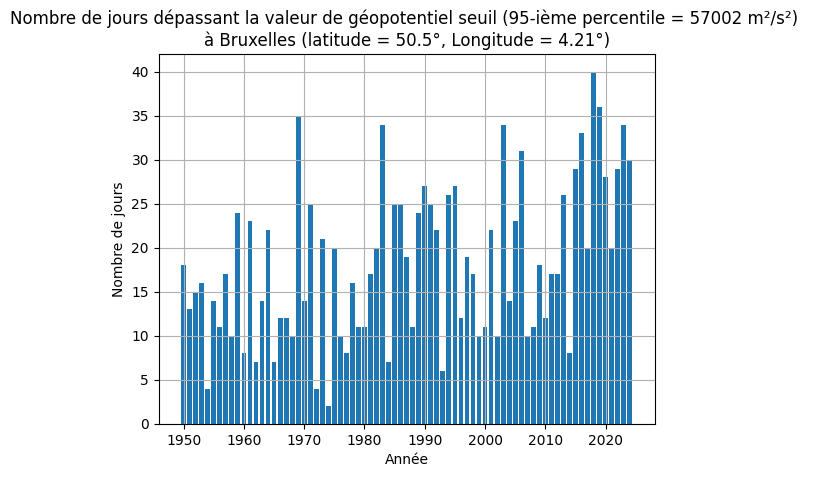

In [36]:
depassement_graph(data_50, "Bruxelles", q=95)

## **3.3 Jours consécutivement au-dessus du seuil**

Maintenant que nous avons un moyen de détecter les jours avec des valeurs de géopotentiel considérées "anormales" selon notre définition de seuil comme un percentile de $95\%$, il faut détecter les périodes où ces jours se succèdent. Nous fixons un minimum de 5 jours consécutifs.

In [30]:
def anomaly(data, place, q, min_days):
    
    lat = coord[place]["latitude"]
    lon = coord[place]["longitude"]
    
    selected_data = data.sel(longitude=lon, latitude=lat, method='nearest')

    dates_list = selected_data['valid_time'].values
    times = pd.to_datetime(selected_data.valid_time.values)
    
    values = selected_data.values.flatten()
    
    threshold = seuil_p(data, place, q)
    
    threshold_values = xr.full_like(selected_data, threshold).values.flatten()
    
    low_values = values[values < threshold_values]
    low_days = times[values < threshold_values]

    high_values = values[values >= threshold_values]
    high_days = times[values >= threshold_values]

    # JOURS CONSECUTIFS
    periods = []  # Liste de périodes consécutives
    current_period = []  # Liste temporaire pour les jours consécutifs

    for i in range(len(high_days)):
        if not current_period:
            current_period.append(high_days[i])
        else:
            if high_days[i] == high_days[i-1] + np.timedelta64(1, 'D'):
                current_period.append(high_days[i])
            else:
                if len(current_period) >= min_days:
                    periods.append(current_period)
                current_period = [high_days[i]]

    if len(current_period) >= min_days:
        periods.append(current_period)

    intensity_list = []

    for period in periods:

        period_dates = pd.to_datetime(period).date
        high_days_dates = pd.to_datetime(high_days).date
        
        mask = np.isin(high_days_dates, period_dates)

        period_values = high_values[mask]
        
        intensity = period_values - threshold
        intensity_list.append(np.mean(intensity))

    # Choix des unités pour le titre
    if threshold > 1000:
        donnee = "géopotentiel"
        unite = "m²/s²"
    else:
        donnee = "température"
        unite = "°C"
    
    print(f"{donnee} à {place} (Longitude = {lon}°, Latitude = {lat}°)")    
    print(f"Période analysée : {str(dates_list[0])[:10]} -> {str(dates_list[-1])[:10]}")
    print(f'\nSur {len(selected_data)} jours, {len(high_values)} jours sont au-dessus du seuil ({threshold:.2f} {unite}), soit {len(high_values) * 100 / len(selected_data):.2f}%.')
    print(f"Il y a {len(periods)} périodes d\'au moins {min_days} jours consécutifs.")

    nombre_liste = []
    duree_liste = []
    intensite_liste = []
    
    for i, p in enumerate(periods):
        formatted_dates = [str(date)[:10] for date in p]
        print(f"\nPériode {i + 1} ({len(p)} jours, intensité moyenne d'anomalie = {intensity_list[i]:.1f} {unite}) : \n{formatted_dates}")
        
        nombre_liste.append(i+1)
        duree_liste.append(len(p))
        intensite_liste.append(intensity_list[i])


    plt.plot(nombre_liste,duree_liste, label = "Durée de la période en jours")
    plt.show()
    plt.plot(nombre_liste,intensite_liste, label = "Durée de la période en jours")
    plt.show()

Une amélioration possible serait de modifier le programme de sorte à ce que si il n'y a qu'un jour en-dessous du seuil entre deux périodes d'anomalies, alors il ne "compte pas" et il s'agit d'une seule longue période d'anomalie.

In [16]:
def courbe(ax, place, initial_date, final_date):
    lat = coord[place]["latitude"]
    lon = coord[place]["longitude"]

    geop_data = data_94.sel(longitude=lon, latitude=lat, method='nearest')
    temp_data = temperature.sel(longitude=lon, latitude=lat, method='nearest')

    geop_data = geop_data.sel(valid_time=slice(initial_date, final_date))
    temp_data = temp_data.sel(valid_time=slice(initial_date, final_date))

    dates_list = geop_data['valid_time'].values
    
    ax.plot(dates_list, geop_data, label="Géopotentiel (m²/s²)", color="blue")

    ax2 = ax.twinx()
    ax2.plot(dates_list, temp_data, label="Température (°C)", color="red", ls="--")

    ax.set_title(f"{initial_date} -> {final_date}", fontsize=10)
    ax.set_ylabel("Géopotentiel (m²/s²)", color="blue")
    ax.tick_params(axis='y', labelcolor="blue")
    ax2.set_ylabel("Température (°C)", color="red")
    ax2.tick_params(axis='y', labelcolor="red")

    ax.tick_params(axis='x', labelrotation=45)


In [ ]:
def duree_intensite():
    

géopotentiel à Bruxelles (Longitude = 4.21°, Latitude = 50.5°)
Période analysée : 1950-01-01 -> 2024-12-31

Sur 27394 jours, 1370 jours sont au-dessus du seuil (57002.32 m²/s²), soit 5.00%.
Il y a 70 périodes d'au moins 5 jours consécutifs.

Période 1 (5 jours, intensité moyenne d'anomalie = 760.8 m²/s²) : 
['1952-06-28', '1952-06-29', '1952-06-30', '1952-07-01', '1952-07-02']

Période 2 (6 jours, intensité moyenne d'anomalie = 474.8 m²/s²) : 
['1955-08-19', '1955-08-20', '1955-08-21', '1955-08-22', '1955-08-23', '1955-08-24']

Période 3 (6 jours, intensité moyenne d'anomalie = 380.3 m²/s²) : 
['1957-07-30', '1957-07-31', '1957-08-01', '1957-08-02', '1957-08-03', '1957-08-04']

Période 4 (7 jours, intensité moyenne d'anomalie = 473.5 m²/s²) : 
['1959-07-04', '1959-07-05', '1959-07-06', '1959-07-07', '1959-07-08', '1959-07-09', '1959-07-10']

Période 5 (5 jours, intensité moyenne d'anomalie = 730.0 m²/s²) : 
['1959-08-23', '1959-08-24', '1959-08-25', '1959-08-26', '1959-08-27']

Période

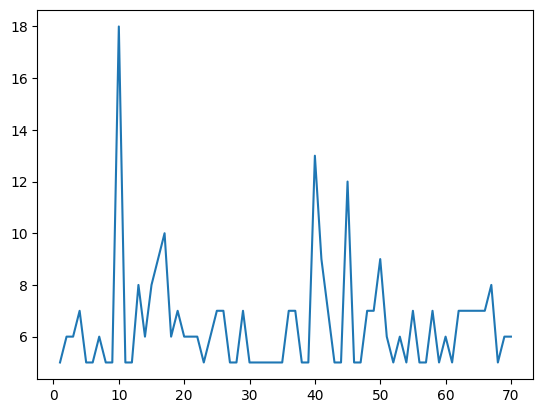

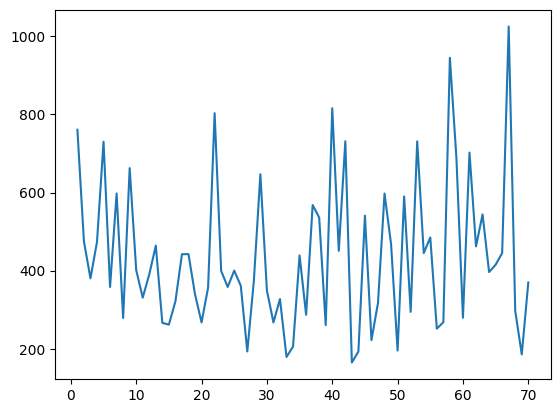

In [31]:
anomaly(data_50, "Bruxelles", q=95, min_days =5)

température à Bruxelles (Longitude = 4.21°, Latitude = 50.5°)
Période analysée : 1950-01-01 -> 2024-12-31

Sur 27394 jours, 1370 jours sont au-dessus du seuil (23.72 °C), soit 5.00%.
Il y a 57 périodes d'au moins 5 jours consécutifs.

Période 1 (5 jours, intensité moyenne d'anomalie = 2.6 °C) : 
['1950-06-03', '1950-06-04', '1950-06-05', '1950-06-06', '1950-06-07']

Période 2 (11 jours, intensité moyenne d'anomalie = 3.8 °C) : 
['1952-06-28', '1952-06-29', '1952-06-30', '1952-07-01', '1952-07-02', '1952-07-03', '1952-07-04', '1952-07-05', '1952-07-06', '1952-07-07', '1952-07-08']

Période 3 (6 jours, intensité moyenne d'anomalie = 2.2 °C) : 
['1955-08-19', '1955-08-20', '1955-08-21', '1955-08-22', '1955-08-23', '1955-08-24']

Période 4 (10 jours, intensité moyenne d'anomalie = 3.4 °C) : 
['1957-06-28', '1957-06-29', '1957-06-30', '1957-07-01', '1957-07-02', '1957-07-03', '1957-07-04', '1957-07-05', '1957-07-06', '1957-07-07']

Période 5 (5 jours, intensité moyenne d'anomalie = 1.7 °C) 

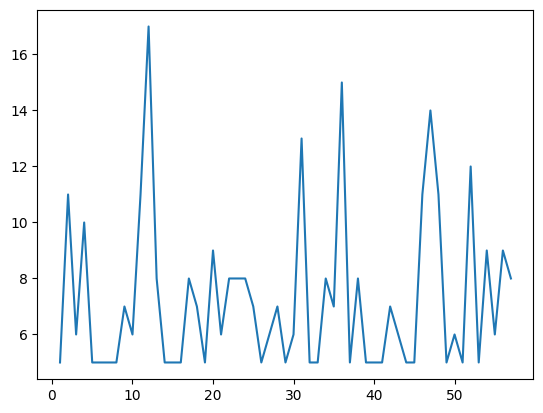

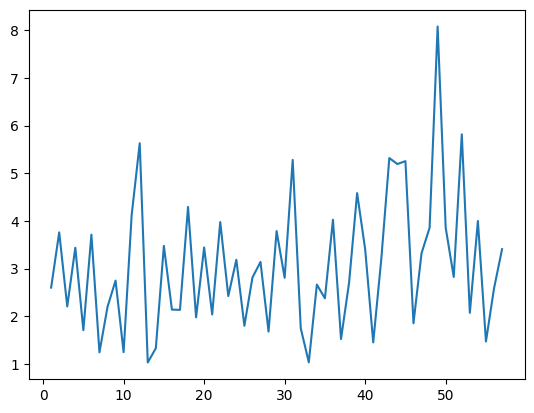

In [32]:
anomaly(temperature_bx, "Bruxelles", q=95, min_days =5)

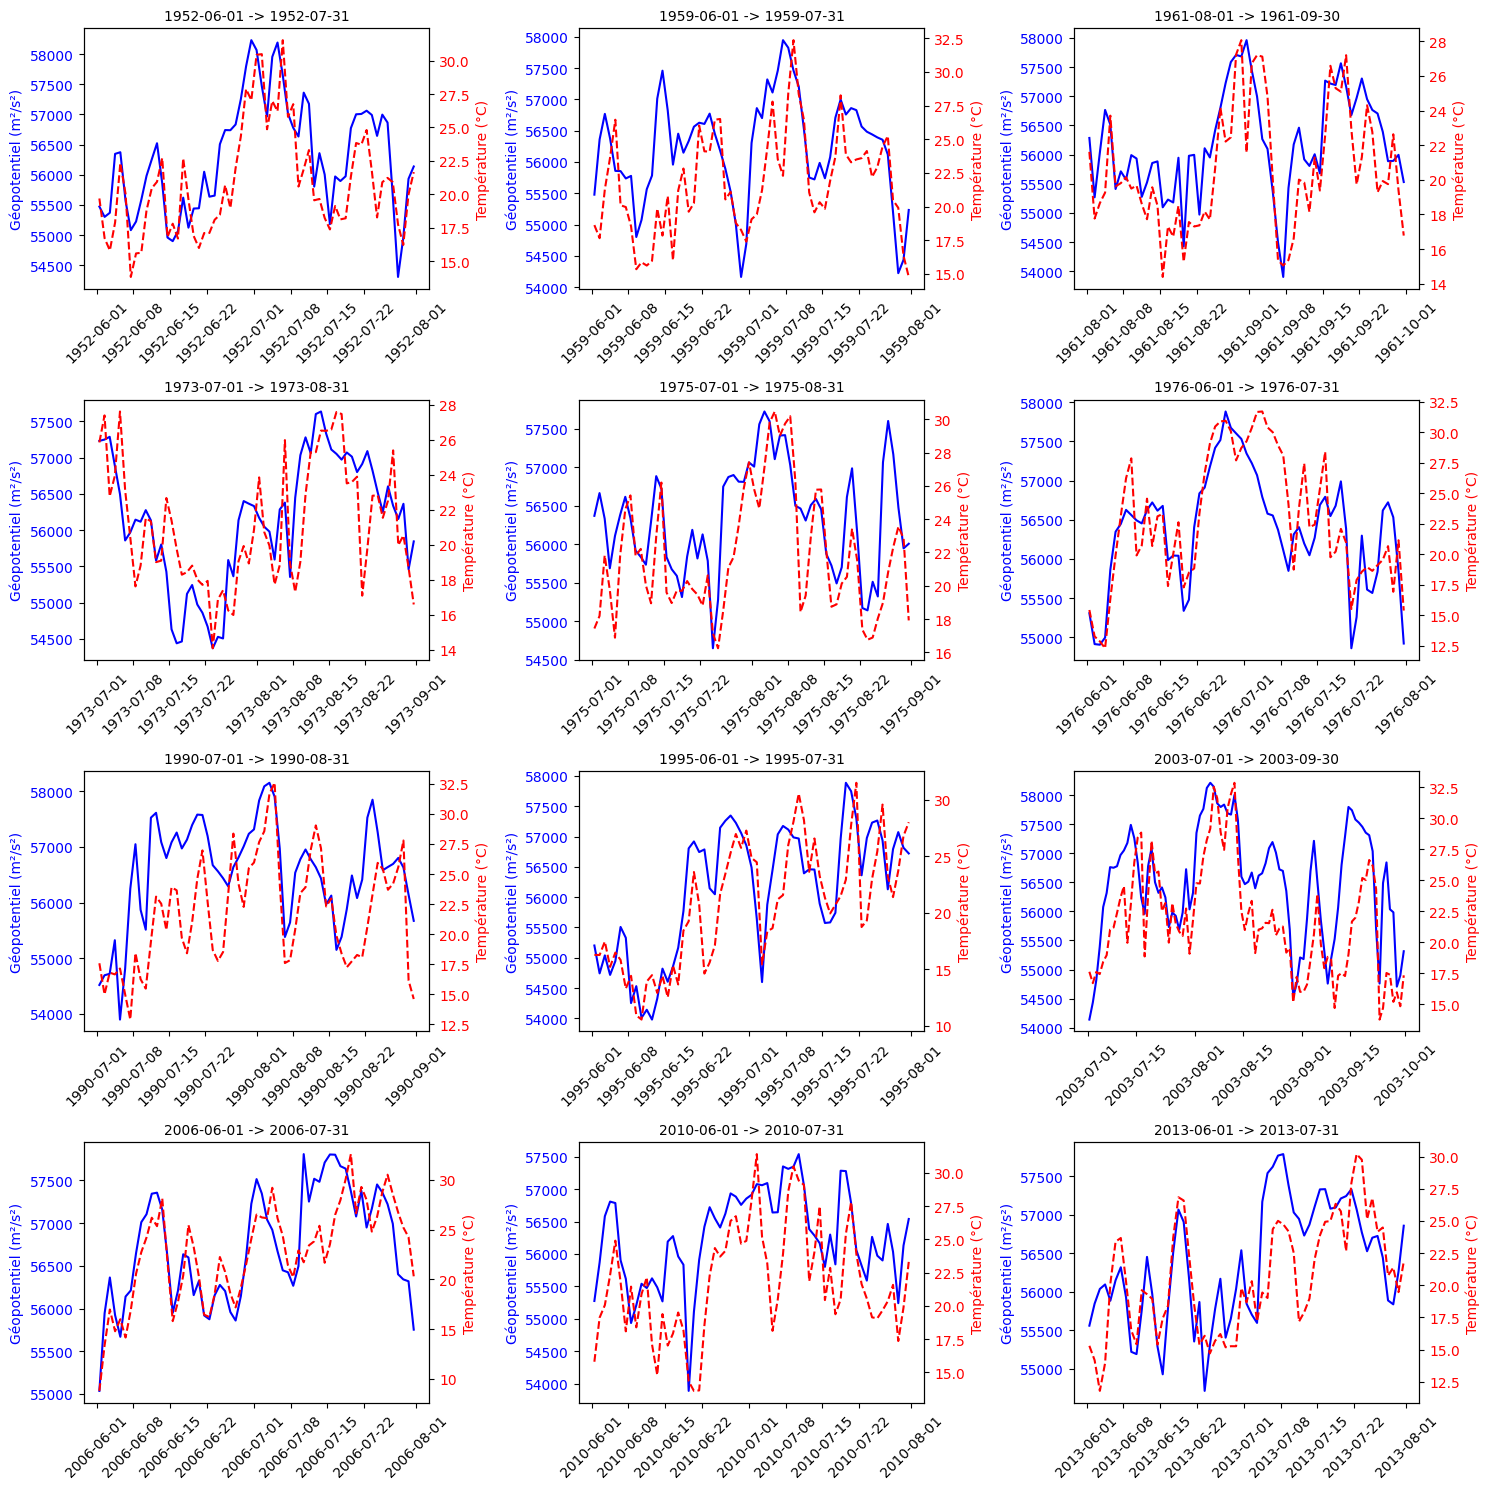

In [34]:
fig, axes = plt.subplots(4, 3, figsize=(15, 15))

periods = [
    ("1952-06-01", "1952-07-31"),
    ("1959-06-01", "1959-07-31"),
    ("1961-08-01", "1961-09-30"),
    ("1973-07-01", "1973-08-31"),
    ("1975-07-01", "1975-08-31"),
    ("1976-06-01", "1976-07-31"),
    ("1990-07-01", "1990-08-31"),
    ("1995-06-01", "1995-07-31"),
    ("2003-07-01", "2003-09-30"),
    ("2006-06-01", "2006-07-31"),
    ("2010-06-01", "2010-07-31"),
    ("2013-06-01", "2013-07-31")
]


for idx, (start, end) in enumerate(periods):
    row, col = divmod(idx, 3)  # Calculer la position dans la grille
    courbe(axes[row, col], "Bruxelles", start, end)

plt.tight_layout()
plt.show()


# 4. BIBLIOGRAPHIE

- Hersbach, H., Bell, B., Berrisford, P., Biavati, G., Horányi, A., Muñoz Sabater, J., Nicolas, J., Peubey, C., Radu, R., Rozum, I., Schepers, D., Simmons, A., Soci, C., Dee, D., Thépaut, J-N. (2023): ERA5 hourly data on pressure levels from 1940 to present. Copernicus Climate Change Service (C3S) Climate Data Store (CDS), DOI: 10.24381/cds.bd0915c6 (Accessed on 23-03-2025)

- Muñoz Sabater, J. (2019): ERA5-Land hourly data from 1950 to present. Copernicus Climate Change Service (C3S) Climate Data Store (CDS). DOI: 10.24381/cds.e2161bac (Accessed on 23-03-2025)

- Goosse, H., Barriat, P. Y., Lefebvre, W., Loutre, M. F., & Zunz, V. (2010). Introduction to climate dynamics and climate modeling. *Cambridge University Press*.
  
- Jain, P., Sharma, A. R., Acuna, D. C., Abatzoglou, J. T., & Flannigan, M. (2024). Record-breaking fire weather in North America in 2021 was initiated by the Pacific northwest heat dome. *Communications Earth & Environment*, 5. doi:10.1038/s43247-024-01346-2

- Neal, E., Huang, C. C., & Nakamura, N. (2022). The 2021 Pacific Northwest heat wave and associated blocking: meteorology and the role of an upstream cyclone as a diabatic source of wave activity. *Geophysical Research Letters*, 49.

- Schumacher, D., Hauser, M., & Seneviratne, S. I. (2022). Drivers and Mechanisms of the 2021 Pacific Northwest Heatwave. *Earth's Future*, 10.

- The Jet Stream. (2023, Septembre). Consulté le Novembre 23, 2024, sur National Ocean and Atmospheric Administration: https://www.noaa.gov/jetstream/global/jet-stream

- White, R. H., Anderson, S., Booth, J. F., Braich, G., Draeger, C., Fei, C., . . . West, G. (2023). The unprecedented Pacific Northwest heatwave of June 2021. *Nature Communications*, 14(727).



-  Barriopedro, D., García-Herrera, R., Ordóñez, C., Miralles, D. G., & Salcedo-Sanz, S. (2023). Heat waves: Physical understanding and scientific challenges. *Reviews of Geophysics*, 61, e2022RG000780. https://doi.org/10.1029/2022RG000780
-  Domeisen, D.I.V., Eltahir, E.A.B., Fischer, E.M. et al. Prediction and projection of heatwaves. *Nat Rev Earth Environ* 4, 36–50 (2023). https://doi.org/10.1038/s43017-022-00371-z
-   McKinnon, K. A., & Simpson, I. R.(2022). How unexpected was the 2021 Pacific Northwest heatwave? *Geophysical Research Letters*, 49, e2022GL100380. https://doi.org/10.1029/2022GL100380